# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

__(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

$\nabla l_{i} = \cfrac{exp(-y_{i}w^{T}x_{i})}{1 + exp(-y_{i}w^{T}x_{i})}(-y_{i})x_{i}$ 

$\nabla Q = \cfrac{1}{n} \sum_{i} \nabla_{w}l_{i}$

$\nabla_{w}^{2}l_{i} = y_{i}^2x_{i}x_{i}^{T} \cfrac{exp(-2y_{i}w^{T}x_{i})}{(1 + exp(-y_{i}w^{T}x_{i}))^{2}}$

$\nabla^{2}_{w}Q = \cfrac{1}{n}\sum_{i}\nabla^{2}_{w}l_{i}$

__(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

In [482]:
dataset = "mushrooms.txt" 

In [483]:
import numpy as np 
from numpy import linalg
from sklearn.datasets import load_svmlight_file  
data = load_svmlight_file(dataset)  
X, y = data[0].toarray(), data[1] 
n, d = X.shape 

In [484]:
y = 2 * (y - 1.5) 
print(y)

[-1.  1.  1. ...  1. -1.  1.]


In [485]:
print(d)

112


In [486]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) 

Найдем константу L = $\lambda_{max}(\nabla^{2}Q)$ Предположим, что $w = 0$ 

$\nabla^{2}Q = \cfrac{1}{4n}\sum_{i}y_{i}^{2}x_{i}x_{i}^{T}$

In [440]:
hessian = np.zeros((d, d))  
for i in range(X_train.shape[0]): 
    hessian += np.dot(X_train[i].reshape(d, 1), X_train[i].reshape(1, d))  
hessian = 1/(4 * X_train.shape[0]) * hessian 

In [441]:
L = np.amax(np.linalg.eigvals(hessian)) 
print(L)

(2.582855288291096+0j)


In [492]:
mu = np.amin(np.linalg.eigvals(hessian)) 
print(mu)

(-1.4592404865732243e-17-7.227342983055726e-18j)


Итого, получаем, что задача выпуклая, но не является сильно выпуклой

In [442]:
class GradientDescent: 
    def __init__(self, d, max_iters = 2 * 10**3, alpha = 1/L, epsilon = 1e-4, l = 1):   
        self.d = d  
        self.w = None  
        self.w_history = []
        self.max_iters = max_iters 
        self.alpha = alpha 
        self.epsilon = epsilon 
        self.l = l 
    
    def grad(self, X, y): 
        Q = 0
        for i in range(X.shape[0]):  
            v = np.exp(-y[i] * np.dot(self.w.T, X[i]))
            Q += v / (1 + v) * (-y[i]) * X[i]  
        Q += 2 * self.l * self.w
        return 1/X.shape[0] * Q
    def fit(self, X, y):  
        self.w = np.zeros(self.d)
        new_w = np.zeros(self.d) 
        for i in range(self.max_iters):  
            new_w = self.w - self.alpha * self.grad(X, y)   
            self.w_history.append(new_w)
            self.w = new_w  
            
    def predict(self, X): 
        return np.dot(X, self.w) 

In [443]:
gd = GradientDescent(d) 

gd.fit(X_train, y_train)  

In [444]:
y_predicted = gd.predict(X_test)  

In [445]:
def accuracy(y_test, y_predicted): 
    return np.sum((y_predicted > 0) == (y_test > 0)) / y_test.shape

print(accuracy(y_test, y_predicted))

[0.99876923]


In [446]:
accuracy_history = [] 
for i in range(0, len(gd.w_history), 100): 
    y_predicted = np.dot(X_test, gd.w_history[i]) 
    accuracy_history.append(accuracy(y_test, y_predicted)) 

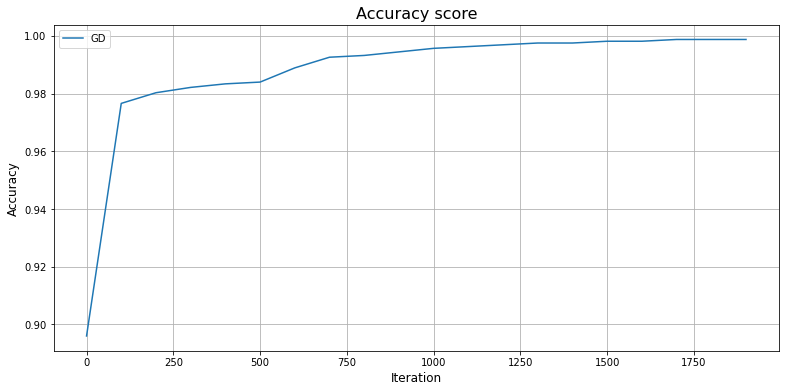

In [447]:
import matplotlib.pyplot as plt   
plt.figure(figsize=(13, 6)) 
plt.plot(range(0, len(gd.w_history), 100), accuracy_history, label='GD') 
plt.title('Accuracy score', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('Accuracy', fontsize=12) 
plt.grid() 
plt.show()

Без регуляризации поулчаются наихудшие результаты, используя регуляризацию, мы видим, что score гораздо сильнее увеличивается, однако так же стоит отметить, что градиенты у логистической регрессии, практически везде равны нулю или близки к нему, поэтому мы и наблюдаем, что то в виде сигмоиды и на графики точности от итерации, т.е есть какой то совсем маленький промежуток, в котором наблюдается действительно хорошее изменение градиентов, и то это только на 5 порядке итераций заметно. 

## Задача 2

__(a)__ Реализуйте метод тяжелого шарика. 

In [502]:
class GradientDescentHeavyBall: 
    def __init__(self, d, max_iters = 2 * 10**3, alpha = 1/L, gamma = 0.1,  epsilon = 1e-4, l = 0.1):   
        self.d = d  
        self.w = None  
        self.w_history = []
        self.max_iters = max_iters 
        self.alpha = alpha 
        self.epsilon = epsilon 
        self.l = l  
        self.gamma = gamma  
        self.convergence_history = []
    
    def grad(self, X, y): 
        Q = 0
        for i in range(X.shape[0]):  
            v = np.exp(-y[i] * np.dot(self.w.T, X[i]))
            Q += v / (1 + v) * (-y[i]) * X[i] 
        Q += 2 * self.l * self.w
        return 1/X.shape[0] * Q 
    
    def fit(self, X, y):  
        self.w = np.random.normal(loc=1, size=self.d)
        new_w = np.ones(self.d) 
        prev_w  = np.ones(self.d)
        for i in range(self.max_iters):  
            new_w = self.w - self.alpha * self.grad(X, y) + self.gamma * (self.w  - prev_w)
            self.w_history.append(new_w) 
            self.convergence_history.append(np.linalg.norm(new_w - self.w)**2)
            tmp = self.w
            self.w = new_w   
            prev_w = self.w   
            
            
    def predict(self, X): 
        return np.dot(X, self.w) 

__(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

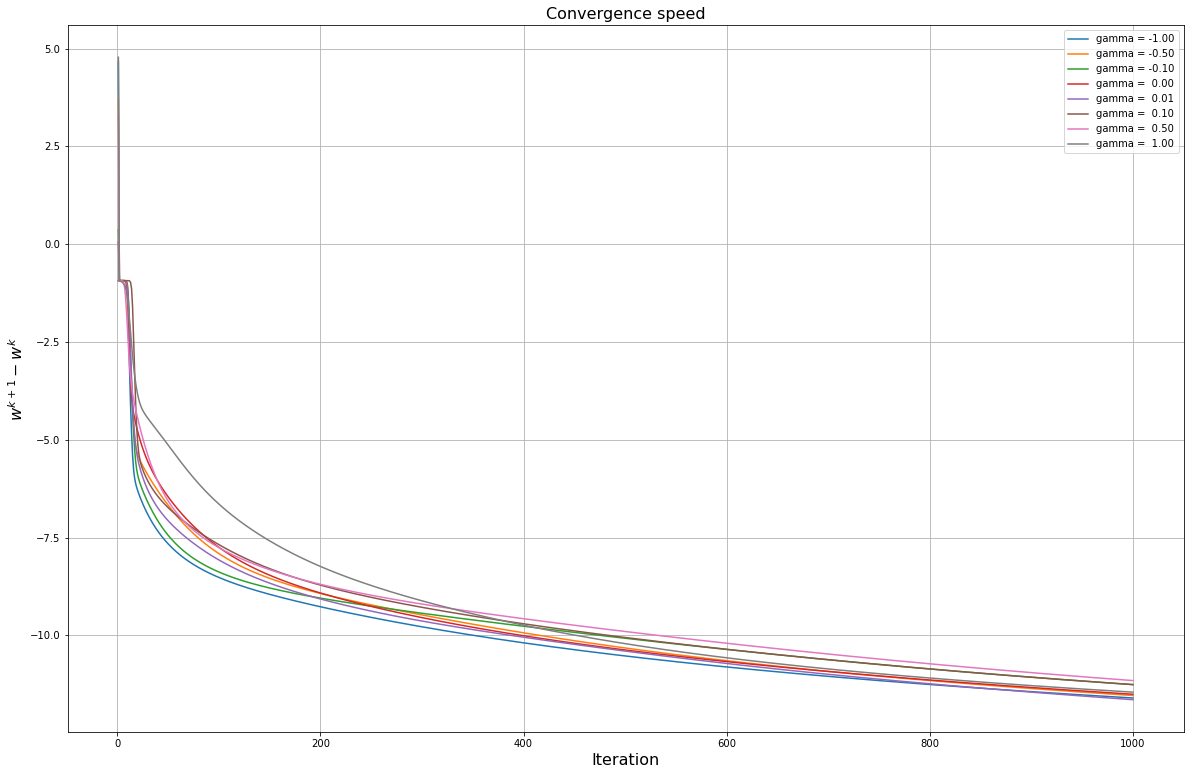

In [503]:
plt.figure(figsize=(20,13))  
gamma = [-1, -0.5, -0.1, 0, 0.01, 0.1, 0.5, 1] 
for i in range(len(gamma)): 
    gd = GradientDescentHeavyBall(d, 10**3, 1/L, gamma[i])  
    gd.fit(X_train, y_train) 
    gd.predict(X_test) 
    plt.plot(range(1, len(gd.convergence_history) + 1, 1), np.log(gd.convergence_history), label='gamma = %5.2f' % gamma[i])   
plt.title('Сonvergence speed', fontsize=16)
plt.xlabel('Iteration', fontsize=16) 
plt.ylabel(r"$w^{k + 1} - w^{k}$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show()

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

In [504]:
gamma = -1
gd = GradientDescentHeavyBall(d, 10**3, 1/L, gamma) 
gd.fit(X_train, y_train)

In [505]:
gd_2 = GradientDescent(d, 10**3, 1/L) 
gd_2.fit(X_train, y_train) 

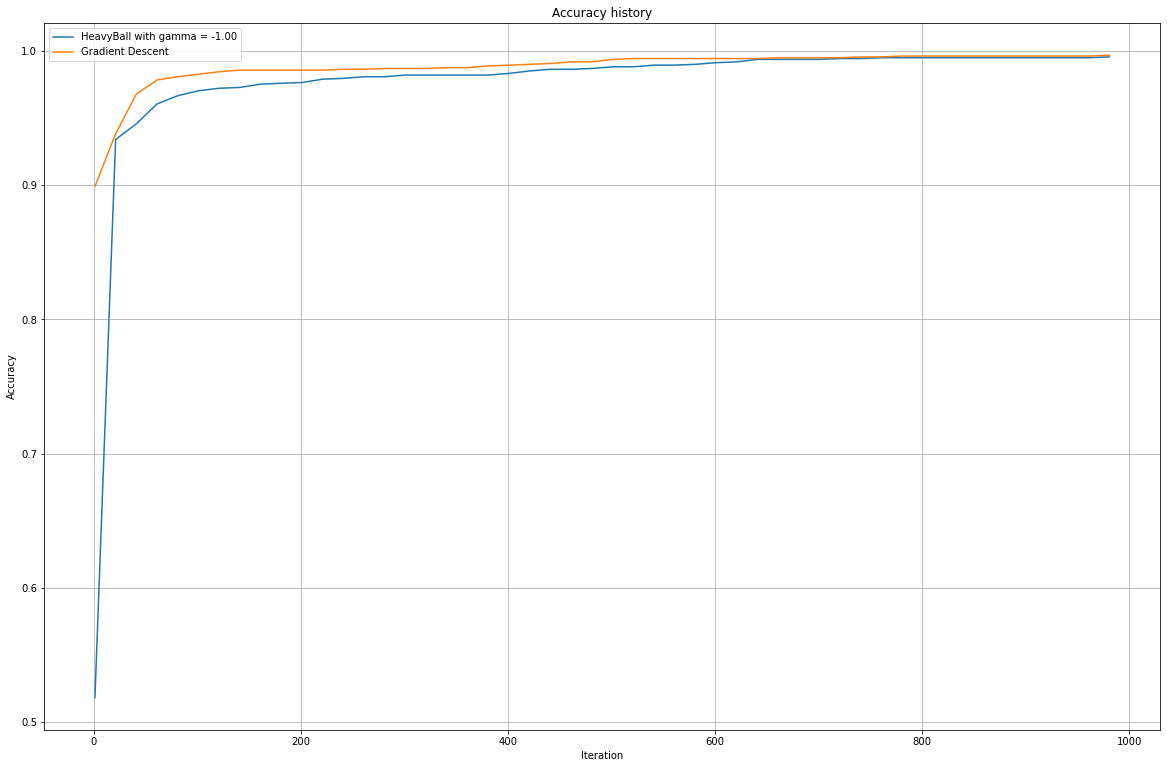

In [506]:
accuracy_history = [] 
accuracy_history_2 = [] 
for i in range(0, 10**3, 20): 
    y_predicted = np.dot(X_test, gd.w_history[i])
    accuracy_history.append(accuracy(y_test, y_predicted))  
    y_predicted_2 = np.dot(X_test, gd_2.w_history[i]) 
    accuracy_history_2.append(accuracy(y_test, y_predicted_2)) 
plt.figure(figsize=(20, 13)) 
plt.title('Accuracy history') 
plt.plot(range(1, 10**3 + 1, 20), accuracy_history, label='HeavyBall with gamma = %5.2f' % gamma) 
plt.plot(range(1, 10**3 + 1, 20), accuracy_history_2, label='Gradient Descent') 
plt.xlabel('Iteration') 
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Видно,что метод тяжелого шарика сходится немного лучше, чем обычный градиентный спуск

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

Регуляризация уже была приведена

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

In [510]:
class GradientDescentNesterovMomentum: 
    def __init__(self, d, max_iters = 2 * 10**3, alpha = 1/L, gamma = 0.1, change=False, bias = 1, epsilon = 1e-4, l = 0.1):   
        self.d = d  
        self.w = None  
        self.w_history = []
        self.max_iters = max_iters 
        self.alpha = alpha 
        self.epsilon = epsilon 
        self.l = l  
        self.gamma = gamma  
        self.convergence_history = [] 
        self.change = change 
        self.bias = bias 
    
    def grad(self, X, y): 
        Q = 0
        for i in range(X.shape[0]):  
            v = np.exp(-y[i] * np.dot(self.w.T, X[i]))
            Q += v / (1 + v) * (-y[i]) * X[i] 
        Q += 2 * self.l * self.w
        return 1/X.shape[0] * Q 
    
    def fit(self, X, y):  
        self.w = np.random.normal(loc=1, size=self.d)
        new_w = np.ones(self.d) 
        prev_w  = np.zeros(self.d)
        for i in range(self.max_iters):  
            t = self.w + self.gamma * (self.w - prev_w)  
            tmp = self.w 
            self.w = t 
            new_w = t - self.alpha * self.grad(X, y) 
            self.w_history.append(new_w) 
            self.convergence_history.append(np.linalg.norm(new_w - tmp)**2)
            self.w = new_w  
            prev_w = self.w  
            if(self.change == True): 
                self.gamma = i/(i + self.bias)
            
    def predict(self, X): 
        return np.dot(X, self.w) 

__(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

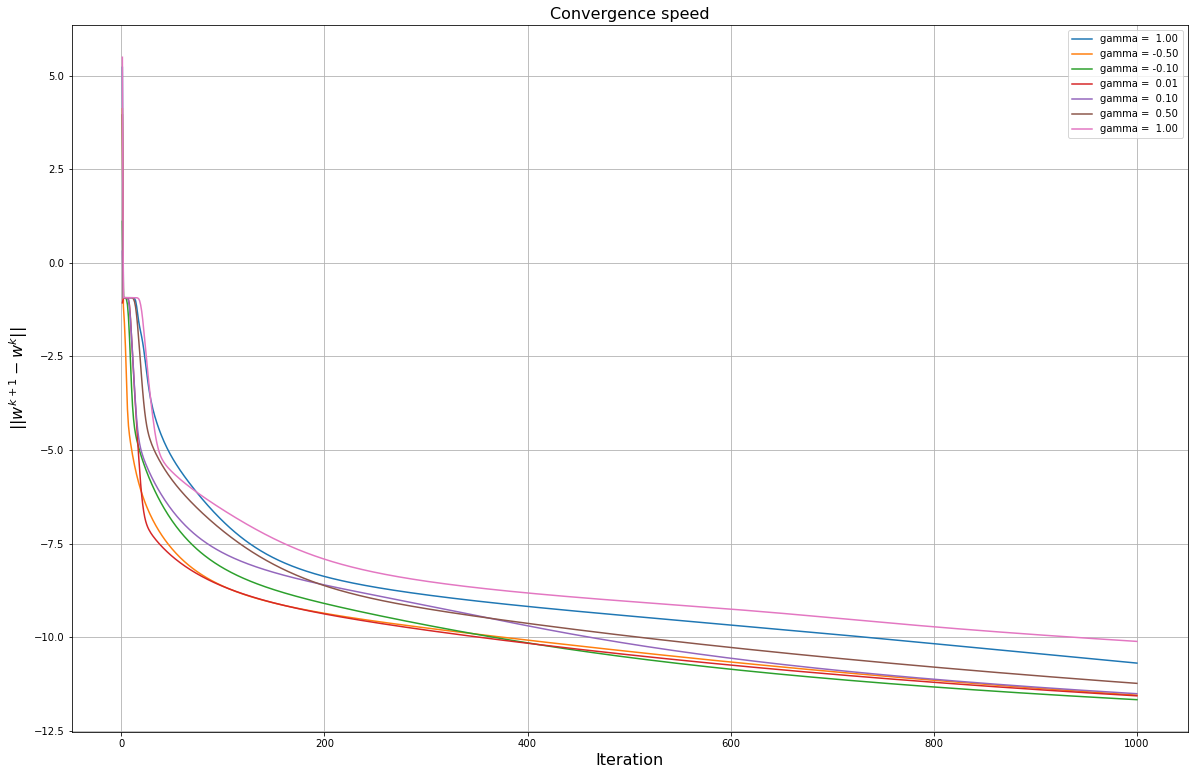

In [513]:
plt.figure(figsize=(20,13))  
gamma = [1, -0.5, -0.1, 0.01, 0.1, 0.5, 1] 
for i in range(len(gamma)): 
    gd = GradientDescentNesterovMomentum(d, 10**3, 1/L, gamma[i], change=False)  
    gd.fit(X_train, y_train) 
    gd.predict(X_test) 
    plt.plot(range(1, len(gd.convergence_history) + 1, 1), np.log(gd.convergence_history), label='gamma = %5.2f' % gamma[i])   
plt.title('Сonvergence speed', fontsize=16)
plt.xlabel('Iteration', fontsize=16) 
plt.ylabel(r"$||w^{k + 1} - w^{k}||$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show()

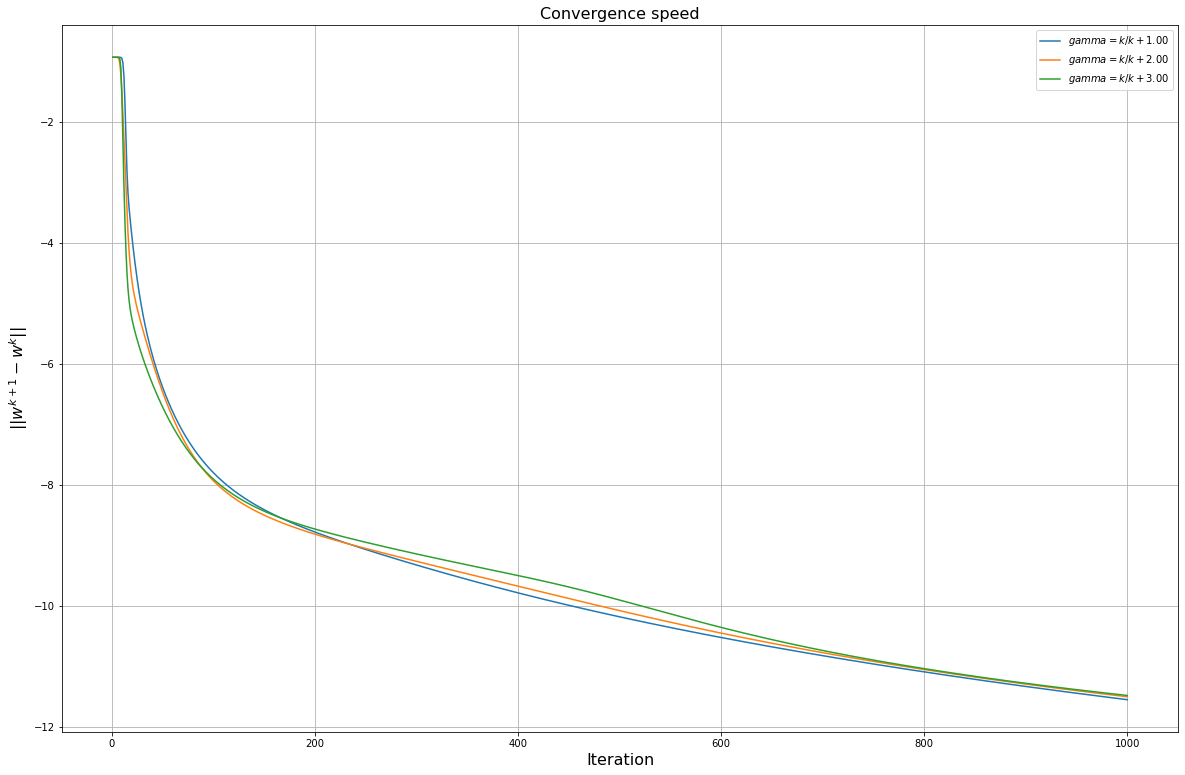

In [520]:
plt.figure(figsize=(20,13)) 
bias = [1, 2, 3] 
for i in range(len(bias)): 
    gd = GradientDescentNesterovMomentum(d, 10**3, 1/L, 0, True, bias[i]) 
    gd.fit(X_train, y_train) 
    gd.predict(X_test) 
    plt.plot(range(1, len(gd.convergence_history) + 1, 1), np.log(gd.convergence_history), label=r'$gamma = k/k + %5.2f$' % bias[i])   
plt.title('Сonvergence speed', fontsize=16)
plt.xlabel('Iteration', fontsize=16) 
plt.ylabel(r"$||w^{k + 1} - w^{k}||$", fontsize=16) 
plt.legend() 
plt.grid() 
plt.show()

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

In [521]:
gamma = -1
gd = GradientDescentHeavyBall(d, 10**3, 1/L, gamma, 0.001, 0) 
gd.fit(X_train, y_train) 

In [522]:
gd_2 = GradientDescent(d, 10**3, 1/L, 0.001, 0) 
gd_2.fit(X_train, y_train)  

In [523]:
gd_3 = GradientDescentNesterovMomentum(d, 10**3, 1/L, -0.1, False, 0, 0) 
gd_3.fit(X_train, y_train) 

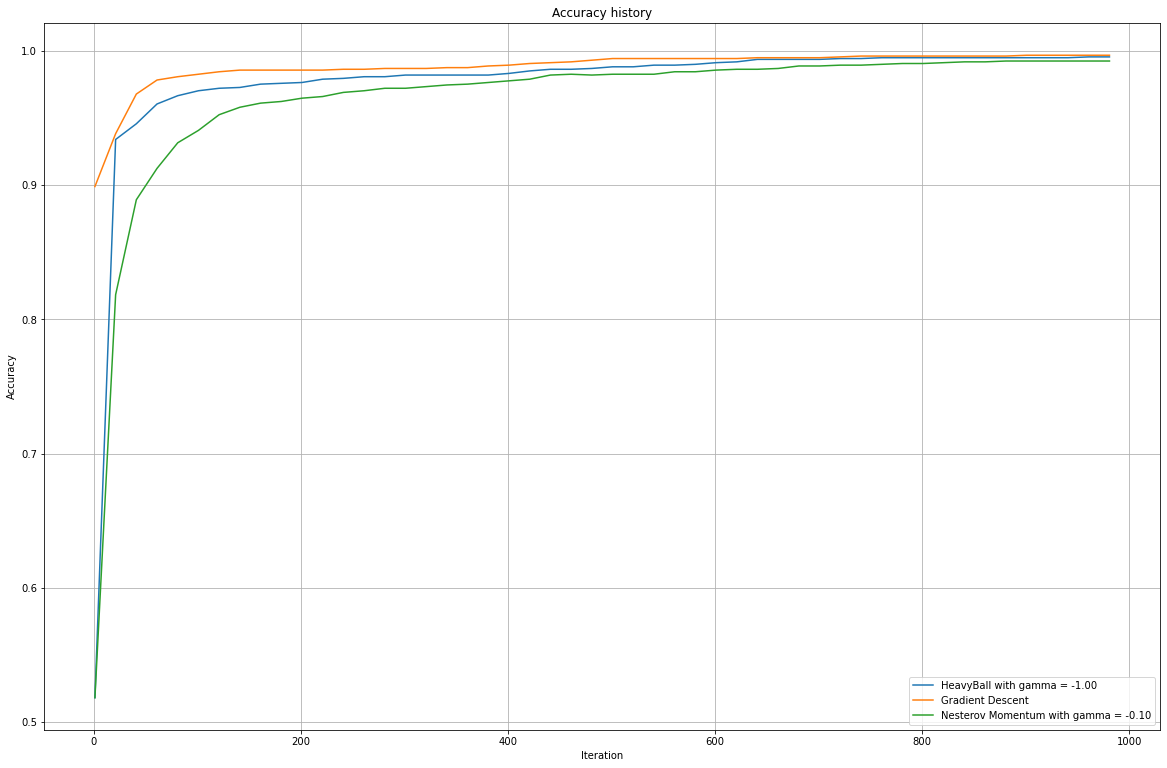

In [524]:
accuracy_history = [] 
accuracy_history_2 = []  
accuracy_history_3 = [] 
for i in range(0, 10**3, 20): 
    y_predicted = np.dot(X_test, gd.w_history[i])
    accuracy_history.append(accuracy(y_test, y_predicted))  
    y_predicted_2 = np.dot(X_test, gd_2.w_history[i]) 
    accuracy_history_2.append(accuracy(y_test, y_predicted_2)) 
    y_predicted_3 = np.dot(X_test, gd_3.w_history[i]) 
    accuracy_history_3.append(accuracy(y_test, y_predicted_3))
plt.figure(figsize=(20, 13)) 
plt.title('Accuracy history') 
plt.plot(range(1, 10**3 + 1, 20), accuracy_history, label='HeavyBall with gamma = %5.2f' % gamma) 
plt.plot(range(1, 10**3 + 1, 20), accuracy_history_2, label='Gradient Descent')  
plt.plot(range(1, 10**3 + 1, 20), accuracy_history_3, label='Nesterov Momentum with gamma = %5.2f' % -0.1)
plt.xlabel('Iteration') 
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

In [ ]:
#ответ

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [ ]:
#ответ

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

In [ ]:
#ответ

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [ ]:
#ответ